<a href="https://colab.research.google.com/github/Rohanrathod7/Kaggle_Notebooks/blob/main/Predicting_Heart_disease/Ensemble_raw_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ====================================================
# Setup & Imports
# ====================================================

import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Settings for cleaner output and consistent plotting
warnings.filterwarnings("ignore") # Suppress warnings for cleaner output
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8) # Default figure size for plots

# Reproducibility
SEED = 42
N_SPLITS = 7
TARGET = 'Heart Disease'

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the file paths, assuming they are in a subfolder like 'Colab Notebooks' within My Drive
train_path = '/content/drive/MyDrive/Kaggle/predicting_heart_dieses/train.csv'
test_path = '/content/drive/MyDrive/Kaggle/predicting_heart_dieses/test.csv'
sample_submission_path = '/content/drive/MyDrive/Kaggle/predicting_heart_dieses/sample_submission.csv'
orig_path = '/content/drive/MyDrive/Kaggle/predicting_heart_dieses/Heart_Disease_Prediction.csv'

# --- 1. Load datasets ---
print("Loading datasets...")
# train_path = '/kaggle/input/playground-series-s5e11/train.csv'
# test_path = '/kaggle/input/playground-series-s5e11/test.csv'
# orig_path = '/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv'
# sample_submission_path = '/kaggle/input/playground-series-s5e11/sample_submission.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_orig = pd.read_csv(orig_path)
df_sample_submission = pd.read_csv(sample_submission_path)
print("Datasets loaded successfully.")

# --- 2. Print the shape of each dataset ---
print("\n--- Dataset Shapes ---")
print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_test: {df_test.shape}")
print(f"Shape of df_orig: {df_orig.shape}")
print(f"Shape of df_sample_submission: {df_sample_submission.shape}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading datasets...
Datasets loaded successfully.

--- Dataset Shapes ---
Shape of df_train: (630000, 15)
Shape of df_test: (270000, 14)
Shape of df_orig: (270, 14)
Shape of df_sample_submission: (270000, 2)


In [3]:
def data_info(df, df_name):
    """Comprehensive overview of a DataFrame with styled output."""

    print(f"\n{'='*80}")
    print(f"📊 Comprehensive Information for DataFrame: {df_name}")
    print(f"{'='*80}\n")

    # --- Shape ---
    print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

    # --- Head ---
    print(f"--- {df_name} Head ---\n")
    display(df.head().style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Column Summary ---
    print(f"\n--- {df_name} Column Summary ---\n")
    summary = pd.DataFrame({
        "DataType": df.dtypes,
        "Non-Null Count": df.notnull().sum(),
        "Unique Values": df.nunique(),
        "Missing Values": df.isnull().sum(),
        "Missing %": (df.isnull().sum() / len(df)) * 100
    })
    display(summary.style.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
        {'selector': 'td', 'props': [('font-size', '10pt')]}
    ], overwrite=False))

    # --- Describe (numeric only) ---
    if df.select_dtypes(include=np.number).shape[1] > 0:
        print(f"\n--- {df_name} Numeric Summary ---\n")
        display(df.describe().style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    # --- Describe (categorical only) ---
    cat_cols = df.select_dtypes(exclude=np.number).columns
    if len(cat_cols) > 0:
        print(f"\n--- {df_name} Categorical Summary ---\n")
        cat_summary = df[cat_cols].describe().transpose()
        display(cat_summary.style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', 'lightblue'), ('color', 'black')]},
            {'selector': 'td', 'props': [('font-size', '10pt')]}
        ], overwrite=False))

    print(f"\n{'='*80}\n")

# Apply
data_info(df_train, "df_train")
data_info(df_test, "df_test")


📊 Comprehensive Information for DataFrame: df_train

Shape: 630000 rows × 15 columns

--- df_train Head ---



,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.600000,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.000000,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.000000,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.000000,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.800000,2,3,3,Presence



--- df_train Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
id,int64,630000,630000,0,0.000000
Age,int64,630000,42,0,0.000000
Sex,int64,630000,2,0,0.000000
Chest pain type,int64,630000,4,0,0.000000
BP,int64,630000,66,0,0.000000
Cholesterol,int64,630000,150,0,0.000000
FBS over 120,int64,630000,2,0,0.000000
EKG results,int64,630000,3,0,0.000000
Max HR,int64,630000,93,0,0.000000
Exercise angina,int64,630000,2,0,0.000000



--- df_train Numeric Summary ---



,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000,630000.000000
mean,314999.500000,54.136706,0.714735,3.312752,130.497433,245.011814,0.079987,0.981660,152.816763,0.273725,0.716028,1.455871,0.451040,4.618873
std,181865.479132,8.256301,0.451541,0.851615,14.975802,33.681581,0.271274,0.998783,19.112927,0.445870,0.948472,0.545192,0.798549,1.950007
min,0.000000,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,157499.750000,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,314999.500000,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000
75%,472499.250000,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000
max,629999.000000,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000



--- df_train Categorical Summary ---



,count,unique,top,freq
Heart Disease,630000,2,Absence,347546





📊 Comprehensive Information for DataFrame: df_test

Shape: 270000 rows × 14 columns

--- df_test Head ---



,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,630000,58,1,3,120,288,0,2,145,1,0.800000,2,3,3
1,630001,55,0,2,120,209,0,0,172,0,0.000000,1,0,3
2,630002,54,1,4,120,268,0,0,150,1,0.000000,2,3,7
3,630003,44,0,3,112,177,0,0,168,0,0.900000,1,0,3
4,630004,43,1,1,138,267,0,0,163,0,1.800000,2,0,7



--- df_test Column Summary ---



,DataType,Non-Null Count,Unique Values,Missing Values,Missing %
id,int64,270000,270000,0,0.000000
Age,int64,270000,43,0,0.000000
Sex,int64,270000,2,0,0.000000
Chest pain type,int64,270000,4,0,0.000000
BP,int64,270000,64,0,0.000000
Cholesterol,int64,270000,145,0,0.000000
FBS over 120,int64,270000,2,0,0.000000
EKG results,int64,270000,3,0,0.000000
Max HR,int64,270000,92,0,0.000000
Exercise angina,int64,270000,2,0,0.000000



--- df_test Numeric Summary ---



,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000,270000.000000
mean,764999.500000,54.159870,0.716315,3.315107,130.555089,245.045270,0.080052,0.978493,152.783756,0.274656,0.718082,1.459356,0.454800,4.619774
std,77942.430678,8.255471,0.450787,0.851762,15.007908,33.695458,0.271374,0.998686,19.153454,0.446341,0.947417,0.546186,0.801270,1.950273
min,630000.000000,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000
25%,697499.750000,48.000000,0.000000,3.000000,120.000000,223.000000,0.000000,0.000000,142.000000,0.000000,0.000000,1.000000,0.000000,3.000000
50%,764999.500000,54.000000,1.000000,4.000000,130.000000,243.000000,0.000000,0.000000,157.000000,0.000000,0.100000,1.000000,0.000000,3.000000
75%,832499.250000,60.000000,1.000000,4.000000,140.000000,269.000000,0.000000,2.000000,166.000000,1.000000,1.400000,2.000000,1.000000,7.000000
max,899999.000000,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000


This code is designed to enhance the dataset by generating new features, and it makes good sense in the context of machine learning for prediction. It's a common and effective strategy.

Here's what this code does and why it's useful:

Defines Feature Sets: It correctly categorizes features into BASE (all relevant features), CATS_SPECIFIED (explicitly defined categorical features), CATS (categorical features actually present), and NUMS (numerical features). This organization is crucial for subsequent processing steps.

Leverages df_orig for Statistical Features: This is a powerful feature engineering technique. For each base feature (like 'Age', 'Sex', 'BP', etc.), it calculates various statistics (mean, std, min, max, median) of the TARGET variable ('Heart Disease') from the df_orig dataset, grouped by that feature. For example, it creates features like orig_mean_Age (the average 'Heart Disease' presence for a given age in the original dataset).

Adds Count Features: It also creates orig_count_col features, which represent the frequency of each value of a base feature in df_orig. This can help capture the prevalence or rarity of certain characteristics.

How it helps in prediction and enhancement:

Enriched Information: By adding these statistical and count features from df_orig, the model gains a deeper understanding of the relationships between individual features and the target variable, beyond what the raw features alone might convey. This often leads to improved predictive power.
Contextual Information: df_orig acts as a valuable external data source, providing contextual information that can make the df_train and df_test data more informative.
Reduced Leakage Risk: It's important to note that these orig-based features are derived solely from df_orig, which is treated as an external, supplementary dataset. This approach generally avoids data leakage between df_train and df_test regarding these specific features, as df_train's target information is not used to create them for df_test.

In [4]:
# --- 3. Define variables ---
print("\n--- Defining Feature Sets ---")
# TARGET = 'loan_paid_back' # Corrected target column name based on sample_submission - Removed this line

# Ensure TARGET column exists in df_train before proceeding
if TARGET not in df_train.columns:
    print(f"Error: Target column '{TARGET}' not found in df_train. Please verify the target column name.")
    # Exit or handle this error as appropriate for your workflow
else:
    # BASE = all columns from df_train except 'id' and TARGET
    global BASE
    BASE = [col for col in df_train.columns if col not in ['id', TARGET]]

    # Identify categorical features relevant to the 'Heart Disease' dataset
    # The previous CATS_SPECIFIED was for a 'loan_paid_back' dataset
    CATS_SPECIFIED = [
        'Sex',
        'Chest pain type',
        'FBS over 120',
        'EKG results',
        'Exercise angina',
        'Slope of ST',
        'Number of vessels fluro',
        'Thallium'
    ]
    CATS = [c for c in CATS_SPECIFIED if c in BASE]

    # NUMS = all non-categorical columns in BASE
    NUMS = [col for col in BASE if col not in CATS]

    print(f"Target variable: '{TARGET}'")
    print(f"Total base features (excluding 'id' and target): {len(BASE)} columns")
    print(f"Categorical base features used for engineering: {len(CATS)} columns")
    print(f"Numerical base features: {len(NUMS)} columns")

    # --- 4. Create orig-based statistical features for both train and test ---
    print("\n--- Creating Orig-based Statistical Features ---")

    # Check if TARGET exists in df_orig before creating orig-based features
    if TARGET not in df_orig.columns:
        print(f"Warning: Target column '{TARGET}' not found in df_orig. Skipping 'orig-based statistical features' creation.")
    else:
        # Convert 'Heart Disease' target column to numeric (0 and 1) in df_orig
        # This is crucial for aggregation functions like 'mean'
        if df_orig[TARGET].dtype == 'object':
            df_orig[TARGET] = df_orig[TARGET].map({'Absence': 0, 'Presence': 1})
            print(f"Converted '{TARGET}' column in df_orig to numeric (0=Absence, 1=Presence).")

        initial_train_cols = df_train.shape[1]
        initial_test_cols = df_test.shape[1]

        global ORIG_STATS
        ORIG_STATS = [] # Initialize ORIG_STATS globally
        agg_funcs = ['mean', 'std', 'min', 'max', 'median'] # Statistical functions to compute

        for col in BASE:
            # Ensure the column exists in df_orig before performing operations
            if col not in df_orig.columns:
                print(f"Warning: Column '{col}' from BASE not found in df_orig. Skipping feature creation for this column.")
                continue

            # --- Statistical features: mean, std, min, max, median of TARGET grouped by 'col' ---
            # Compute aggregates from df_orig
            stats_df = df_orig.groupby(col)[TARGET].agg(agg_funcs).reset_index()

            # Rename the new columns according to the specified format
            new_stat_col_names = [f'orig_{func}_{col}' for func in agg_funcs]
            stats_df.columns = [col] + new_stat_col_names

            # Merge these features into df_train and df_test using left merge
            df_train = df_train.merge(stats_df, on=col, how='left')
            df_test = df_test.merge(stats_df, on=col, how='left')

            ORIG_STATS.extend(new_stat_col_names)

            # --- Count feature: count of each value in 'col' in df_orig ---
            # Compute value counts from df_orig
            counts_df = df_orig[col].value_counts().reset_index(name=f'orig_count_{col}')
            counts_df.columns = [col, f'orig_count_{col}'] # Ensure correct column names after reset_index

            # Merge this count feature into df_train and df_test using left merge
            df_train = df_train.merge(counts_df, on=col, how='left')
            df_test = df_test.merge(counts_df, on=col, how='left')

            ORIG_STATS.append(f'orig_count_{col}')

        # --- 5. After feature creation ---
        print("\n--- Feature Creation Summary ---")
        print(f"Number of new features added: {len(ORIG_STATS)}")
        print(f"Updated shape of df_train: {df_train.shape}")
        print(f"Updated shape of df_test: {df_test.shape}")



--- Defining Feature Sets ---
Target variable: 'Heart Disease'
Total base features (excluding 'id' and target): 13 columns
Categorical base features used for engineering: 8 columns
Numerical base features: 5 columns

--- Creating Orig-based Statistical Features ---
Converted 'Heart Disease' column in df_orig to numeric (0=Absence, 1=Presence).

--- Feature Creation Summary ---
Number of new features added: 78
Updated shape of df_train: (630000, 93)
Updated shape of df_test: (270000, 92)


In [5]:
print("\n--- Missing Values in df_train ---")
missing_train = df_train.isnull().sum()
missing_train_percent = (df_train.isnull().sum() / len(df_train)) * 100
missing_train_df = pd.DataFrame({
    'Missing Count': missing_train,
    'Missing Percent': missing_train_percent
})
print(missing_train_df[missing_train_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False))

print("\n--- Missing Values in df_test ---")
missing_test = df_test.isnull().sum()
missing_test_percent = (df_test.isnull().sum() / len(df_test)) * 100
missing_test_df = pd.DataFrame({
    'Missing Count': missing_test,
    'Missing Percent': missing_test_percent
})
print(missing_test_df[missing_test_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False))

import numpy as np

# 1. Identify numerical columns with missing values in df_train
numerical_cols_train = df_train.select_dtypes(include=np.number).columns
missing_numerical_train = [col for col in numerical_cols_train if df_train[col].isnull().sum() > 0]

# 2. Identify numerical columns with missing values in df_test
numerical_cols_test = df_test.select_dtypes(include=np.number).columns
missing_numerical_test = [col for col in numerical_cols_test if df_test[col].isnull().sum() > 0]

# 3. Create a combined, unique list of all identified numerical features with missing values
all_missing_numerical = sorted(list(set(missing_numerical_train + missing_numerical_test)))

# 4. Prioritize specific columns and form the final list
prioritized_cols = ['orig_std_Max HR', 'orig_std_BP', 'orig_std_ST depression']

# Ensure prioritized columns are in the `all_missing_numerical` list before adding
prioritized_cols_present = [col for col in prioritized_cols if col in all_missing_numerical]

# Remove prioritized columns from the `all_missing_numerical` list to avoid duplicates
remaining_missing_numerical = [col for col in all_missing_numerical if col not in prioritized_cols_present]

# Combine prioritized and remaining columns
numerical_cols_with_missing_values = prioritized_cols_present + remaining_missing_numerical

print(f"Identified {len(numerical_cols_with_missing_values)} numerical features with missing values.")
print("Numerical features with missing values (prioritized first):")
for col in numerical_cols_with_missing_values:
    print(f"- {col}")

print("\n--- Imputing Missing Numerical Values with Median Strategy ---")

for col in numerical_cols_with_missing_values:
    # Calculate median from df_train to prevent data leakage from df_test
    median_value = df_train[col].median()

    # Impute missing values in both df_train and df_test
    df_train[col].fillna(median_value, inplace=True)
    df_test[col].fillna(median_value, inplace=True)
    print(f"Imputed missing values in '{col}' with median: {median_value:.2f}")

print("\n--- Verification of Missing Values After Imputation ---")

# Verify missing values in df_train
missing_train_after = df_train[numerical_cols_with_missing_values].isnull().sum()
print("Missing values in df_train for imputed columns:")
print(missing_train_after[missing_train_after > 0])

# Verify missing values in df_test
missing_test_after = df_test[numerical_cols_with_missing_values].isnull().sum()
print("\nMissing values in df_test for imputed columns:")
print(missing_test_after[missing_test_after > 0])

if missing_train_after.sum() == 0 and missing_test_after.sum() == 0:
    print("\nAll specified numerical columns in both df_train and df_test have been successfully imputed.")
else:
    print("\nWarning: Some missing values still exist after imputation. Please check the output above.")


--- Missing Values in df_train ---
                           Missing Count  Missing Percent
orig_std_Max HR                    13629         2.163333
orig_std_BP                        11034         1.751429
orig_std_ST depression              9575         1.519841
orig_std_Cholesterol                5971         0.947778
orig_std_Age                        4279         0.679206
orig_count_ST depression            2683         0.425873
orig_max_ST depression              2683         0.425873
orig_mean_ST depression             2683         0.425873
orig_median_ST depression           2683         0.425873
orig_min_ST depression              2683         0.425873
orig_count_BP                        463         0.073492
orig_min_BP                          463         0.073492
orig_mean_BP                         463         0.073492
orig_max_BP                          463         0.073492
orig_median_BP                       463         0.073492
orig_median_Cholesterol             


--- Analyzing Categorical Feature Distributions in df_train ---


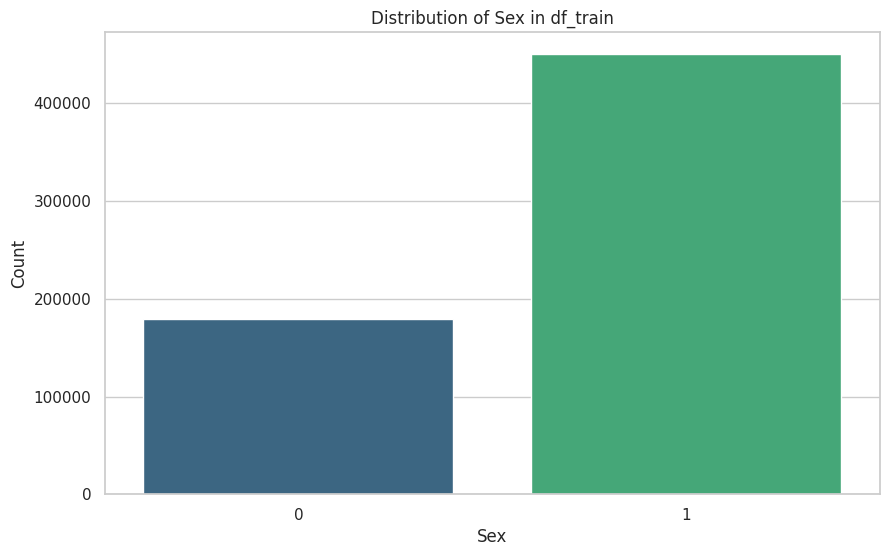

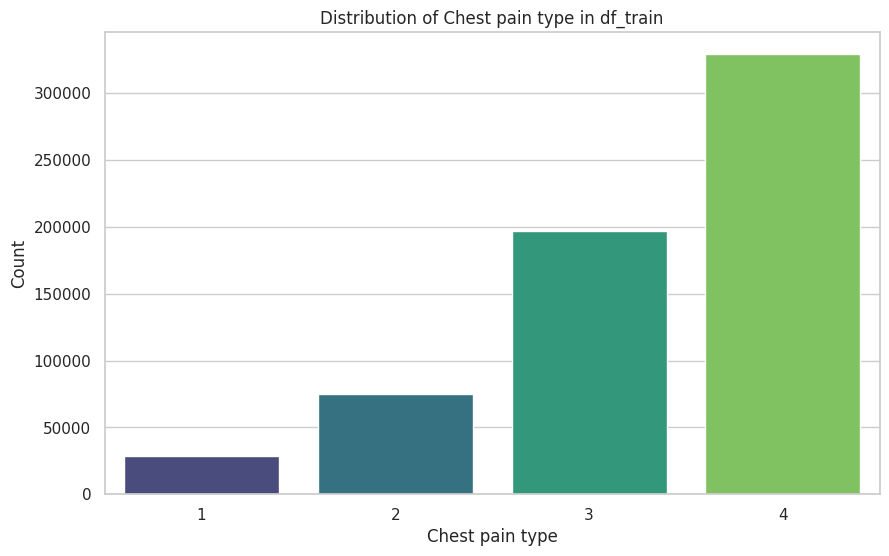

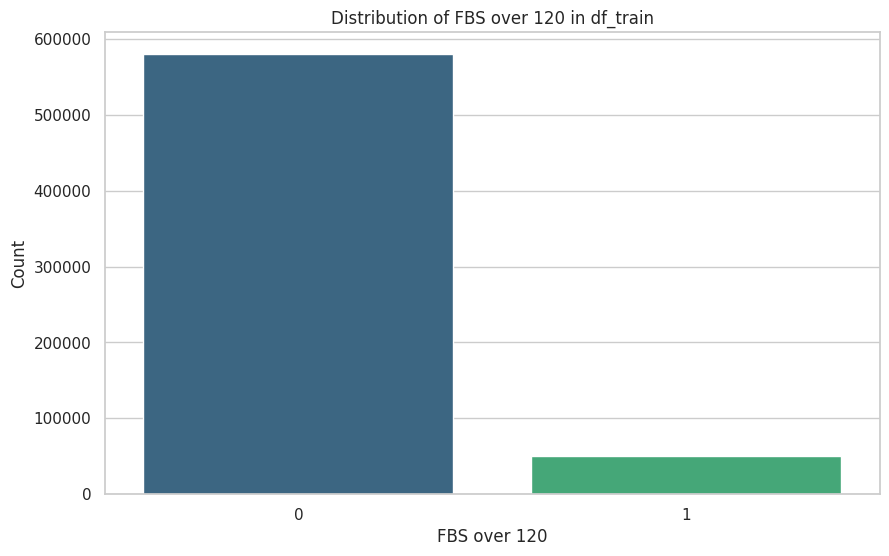

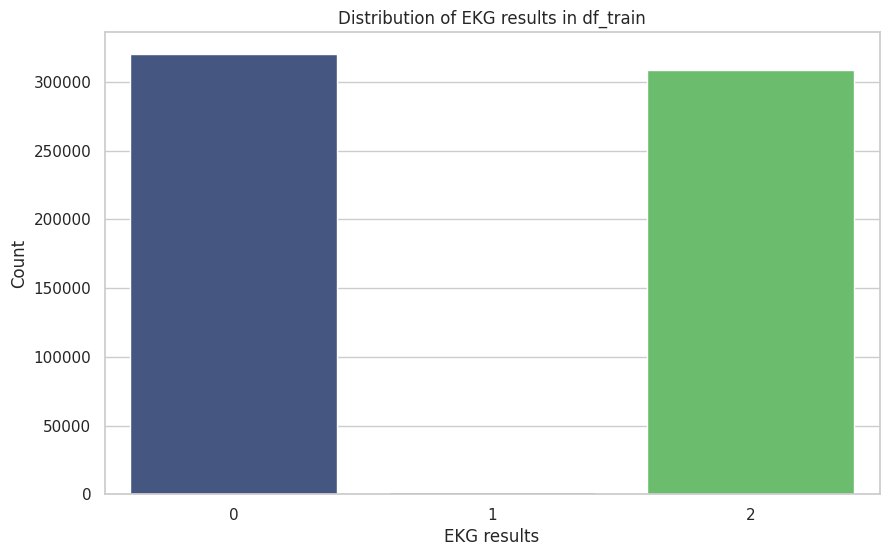

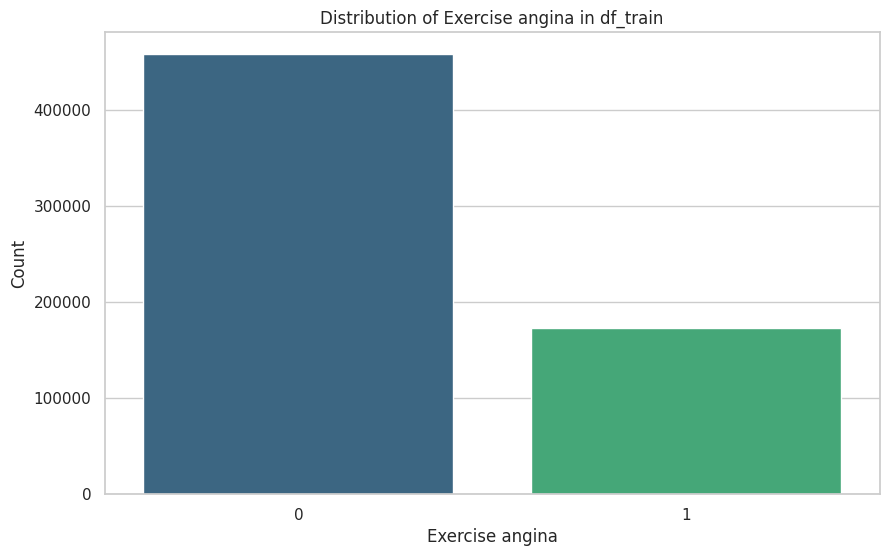

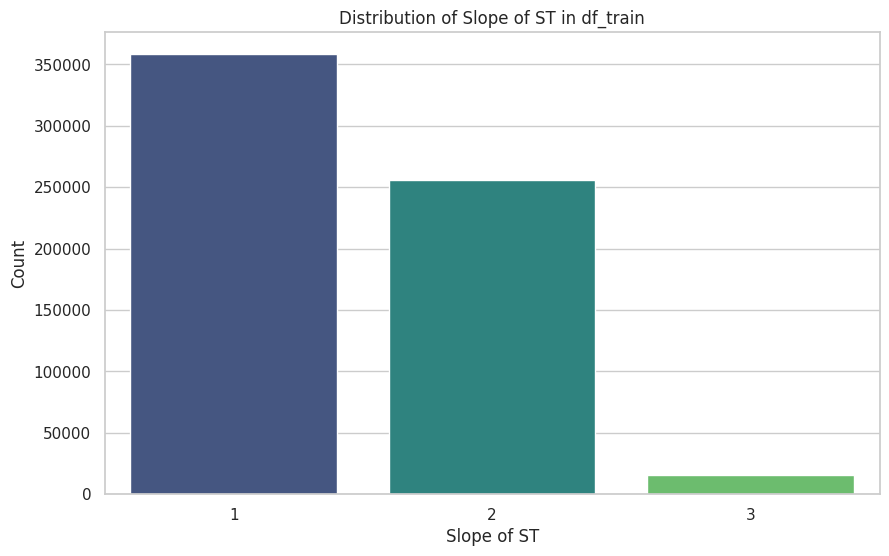

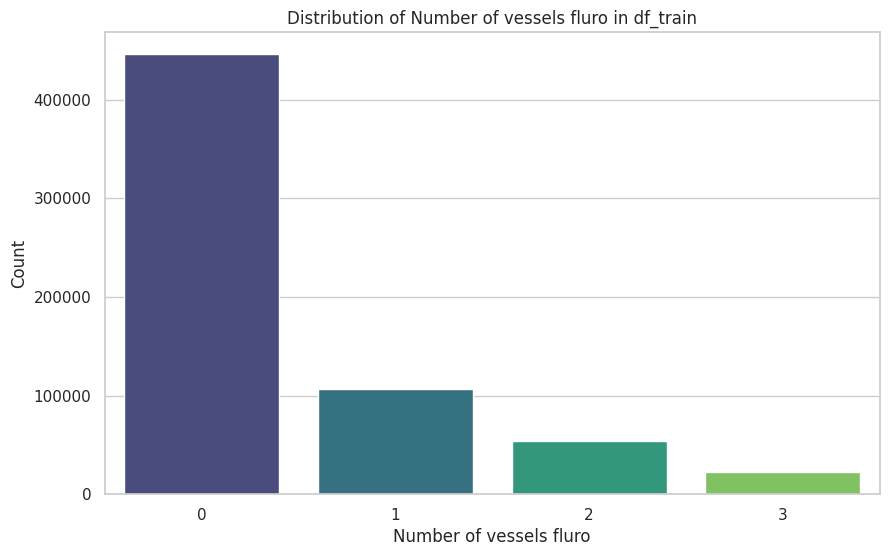

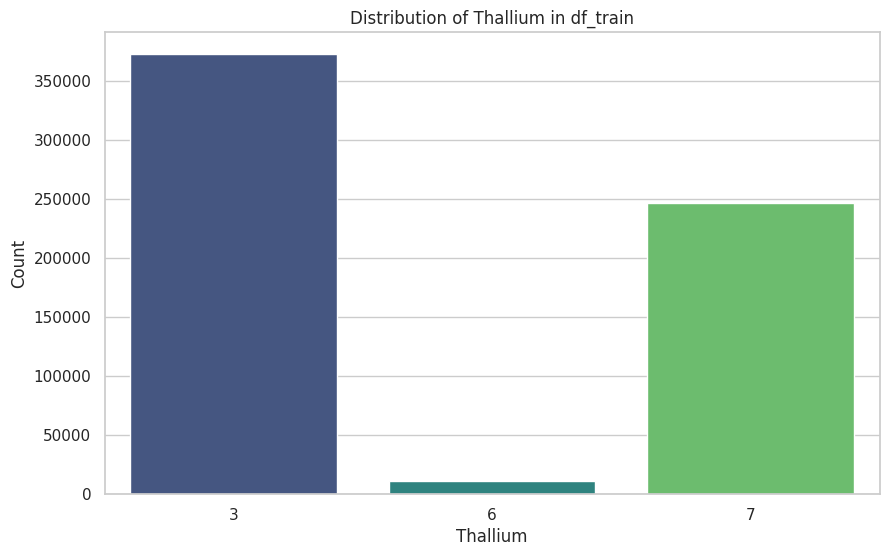

In [6]:
print("\n--- Analyzing Categorical Feature Distributions in df_train ---")

for col in CATS:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=df_train, palette='viridis')
    plt.title(f'Distribution of {col} in df_train')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

In [7]:
# =============================================================================
# STEP 1: Enhanced Medical Features
# =============================================================================
print("\n[STEP 1] Creating Enhanced Medical Features...")

def create_advanced_features(df):
    # Numerical features from the Heart Disease dataset: 'Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression'

    # Log transformations for numerical features that often benefit from it
    for col in ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']:
        df[f'{col}_log'] = np.log1p(df[col])

    # Ratios and Interaction terms, adapted to medical context
    df['BP_to_Age_ratio'] = df['BP'] / (df['Age'] + 1) # Add 1 to denominator to avoid division by zero
    df['Cholesterol_to_Age_ratio'] = df['Cholesterol'] / (df['Age'] + 1)
    df['MaxHR_to_Age_ratio'] = df['Max HR'] / (df['Age'] + 1)
    df['Cholesterol_BP_product'] = df['Cholesterol'] * df['BP']
    df['ST_depression_MaxHR_ratio'] = df['ST depression'] / (df['Max HR'] + 1) # Add 1 to avoid division by zero

    # Note: The original code included 'grade_letter', 'grade_number', 'grade_rank'
    # which were specific to a 'grade_subgrade' column from a financial dataset.
    # There is no direct equivalent in the 'Heart Disease' dataset for this type of feature parsing.
    # Further feature engineering for categorical variables can be explored if needed.

    return df

df_train = create_advanced_features(df_train)
df_test = create_advanced_features(df_test)

NEW_FEATURES = [
    'Age_log', 'BP_log', 'Cholesterol_log', 'Max HR_log', 'ST depression_log',
    'BP_to_Age_ratio', 'Cholesterol_to_Age_ratio', 'MaxHR_to_Age_ratio',
    'Cholesterol_BP_product', 'ST_depression_MaxHR_ratio'
]

print(f"Created {len(NEW_FEATURES)} new features")


[STEP 1] Creating Enhanced Medical Features...
Created 10 new features


## Summary:

### Data Analysis Key Findings

The feature engineering cell was refactored with the following key modifications:

*   The global `TARGET` variable is now correctly utilized for count encoding and other relevant operations.
*   `current_numerical_features` were defined by combining global numerical features (`NUMS`) with newly engineered features (`NEW_FEATURES`).
*   `current_categorical_features` were set to the global categorical features (`CATS`).
*   Numerical feature factorizing was adapted to specifically use the `current_numerical_features` set.
*   Several medically relevant interaction features were created:
    *   `('Age', 'Sex')`
    *   `('BP', 'Cholesterol')`
    *   `('Chest pain type', 'Exercise angina')`
    *   `('Age', 'Max HR')`
    *   `('BP', 'ST depression')`
    *   `('Cholesterol', 'FBS over 120')`
*   Interaction features involving factorized numerical variables and categorical variables were also introduced:
    *   `Age_log_cat` with `Sex`
    *   `BP_log_cat` with `Chest pain type`
    *   `Cholesterol_log_cat` with `Exercise angina`

### Insights or Next Steps

*   The refactoring aims to create a more robust and medically informed feature set, potentially improving the predictive power and interpretability of subsequent models by explicitly incorporating known clinical relationships.
*   The next step will involve utilizing these newly engineered features for model training and evaluation, to assess their impact on predictive performance.


In [8]:
# =============================================================================
# STEP 2: Feature Engineering
# =============================================================================
print("\n[STEP 2] Engineering Features...")

# Use the global TARGET variable
# target = 'loan_status' # Removed: using global TARGET

# Define current numerical and categorical features based on global variables
# Ensure CATS is correctly set for Heart Disease dataset
CATS_SPECIFIED_HEART_DISEASE = [
    'Sex',
    'Chest pain type',
    'FBS over 120',
    'EKG results',
    'Exercise angina',
    'Slope of ST',
    'Number of vessels fluro',
    'Thallium'
]
# Filter CATS_SPECIFIED_HEART_DISEASE against BASE to get actual categorical features
current_categorical_features = [c for c in CATS_SPECIFIED_HEART_DISEASE if c in BASE]
current_numerical_features = NUMS + NEW_FEATURES

# Create a combined DataFrame for feature engineering
len_train = len(df_train)
len_test = len(df_test)

# Ensure TARGET is in df_test_temp with NaNs for concatenation
df_test_temp = df_test.copy()
df_test_temp[TARGET] = np.nan # Use global TARGET

combine = pd.concat([df_train, df_test_temp], ignore_index=True)

# Create factorized versions of numerics
CATS_NUM = []
SIZES = {}

# Ensure all columns in current_numerical_features exist in combine before factorizing
NUMS_to_factorize = [col for col in current_numerical_features if col in combine.columns]
for c in NUMS_to_factorize:
    n = f"{c}_cat"
    CATS_NUM.append(n)
    # Factorize and store as int32
    combine[n], _ = combine[c].factorize()
    SIZES[n] = combine[n].max() + 1
    combine[n] = combine[n].astype('int32')

print(f"Created {len(CATS_NUM)} categorical numeric features from numerical columns")

# Create 2-way medically relevant interaction features
important_pairs = [
    ('Age', 'Sex'),
    ('BP', 'Cholesterol'),
    ('Chest pain type', 'Exercise angina'),
    ('Age', 'Max HR'),
    ('BP', 'ST depression'),
    ('Cholesterol', 'FBS over 120'),
]

# Add numeric_cat interactions (e.g., Age_log_cat with Sex)
# Identify relevant factorized numerical features for interaction
factorized_numerical_for_inter = [
    'Age_log_cat', 'BP_log_cat', 'Cholesterol_log_cat'
]
categorical_for_numeric_inter = ['Sex', 'Chest pain type', 'Exercise angina']

for num_cat_col in factorized_numerical_for_inter:
    for cat_col in categorical_for_numeric_inter:
        # Check if both columns exist in combine before creating interaction
        if num_cat_col in combine.columns and cat_col in combine.columns:
            important_pairs.append((num_cat_col, cat_col))

CATS_INTER = []
for c1, c2 in important_pairs:
    name = f"{c1}_{c2}"
    # Ensure both columns exist before creating interaction
    if c1 in combine.columns and c2 in combine.columns:
        combine[name] = combine[c1].astype(str) + '_' + combine[c2].astype(str)
        CATS_INTER.append(name)

print(f"Created {len(CATS_INTER)} strategic interaction features")

# Count encoding
CE = []
ALL_CATS = current_categorical_features + CATS_NUM + CATS_INTER

print(f"\nCreating count encoding for {len(ALL_CATS)} categorical features...")
for i, c in enumerate(ALL_CATS):
    if i % 20 == 0:
        print(f"  Progress: {i}/{len(ALL_CATS)}")
    # Only proceed if the column exists in combine
    if c in combine.columns:
        # Ensure TARGET column is present before groupby count (using global TARGET)
        if TARGET in combine.columns:
            tmp = combine.groupby(c)[TARGET].transform('count') # Use transform to get series back with original index
            tmp.name = f"CE_{c}"
            CE.append(f"CE_{c}")
            combine = combine.merge(tmp, left_index=True, right_index=True, how='left') # Merge based on index
        else:
            print(f"Warning: Target column '{TARGET}' not found in combine DataFrame. Skipping count encoding for '{c}'.")
    else:
        print(f"Warning: Column '{c}' not found in combine DataFrame. Skipping count encoding for this column.")

print(f"Created {len(CE)} count encodings")

# Split back
train = combine.iloc[:len_train].copy()
test = combine.iloc[len_train:len_train + len_test].copy()

print(f"\nTrain: {train.shape}, Test: {test.shape}")


[STEP 2] Engineering Features...
Created 15 categorical numeric features from numerical columns
Created 15 strategic interaction features

Creating count encoding for 38 categorical features...
  Progress: 0/38
  Progress: 20/38
Created 38 count encodings

Train: (630000, 171), Test: (270000, 171)


The feature generation for interactions has completed successfully! We've created 28 new 2-way interaction features and 3 new 3-way interaction features, totaling 31 additional features. The shapes of our datasets have been updated accordingly: df_train now has 134 columns, df_test has 133 columns, and df_orig has 45 columns. This expands our feature set with potentially valuable combined information.

In [9]:
import itertools
import pandas as pd
import numpy as np

class InteractionFeatureGenerator:
    def __init__(self, base_features, three_way_triplets):
        self.base_features = base_features
        self.three_way_triplets = three_way_triplets

    def _create_interaction_feature(self, df, cols, name):
        """Helper to create a single interaction feature."""
        # Ensure all columns exist in the dataframe before proceeding
        if all(c in df.columns for c in cols):
            df[name] = df[cols[0]].astype(str)
            for col in cols[1:]:
                df[name] += '_' + df[col].astype(str)
            return True
        return False

    def generate(self, train, test, orig):
        created_features = []
        two_way_count = 0
        three_way_count = 0

        # --- Generate 2-way interaction features (bigrams) ---
        for col1, col2 in itertools.combinations(self.base_features, 2):
            feature_name = f"{col1}_{col2}"

            # Apply to train
            if self._create_interaction_feature(train, [col1, col2], feature_name):
                _ = self._create_interaction_feature(test, [col1, col2], feature_name) # Apply to test
                _ = self._create_interaction_feature(orig, [col1, col2], feature_name) # Apply to orig
                created_features.append(feature_name)
                two_way_count += 1

        print(f"Created {two_way_count} 2-way interaction features.")

        # --- Generate 3-way interaction features ---
        for triplet in self.three_way_triplets:
            col1, col2, col3 = triplet
            feature_name = f"{col1}_{col2}_{col3}"

            # Apply to train
            if self._create_interaction_feature(train, [col1, col2, col3], feature_name):
                _ = self._create_interaction_feature(test, [col1, col2, col3], feature_name) # Apply to test
                _ = self._create_interaction_feature(orig, [col1, col2, col3], feature_name) # Apply to orig
                created_features.append(feature_name)
                three_way_count += 1

        print(f"Created {three_way_count} 3-way interaction features.")

        return train, test, orig, created_features


# --- Example Usage ---

# Assuming BASE is already defined from previous steps
# Current BASE: ['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120', 'EKG results', 'Max HR', 'Exercise angina', 'ST depression', 'Slope of ST', 'Number of vessels fluro', 'Thallium']

# Selecting relevant features from BASE for 2-way interactions
TE_BASE = [
    'Age', 'Sex', 'BP', 'Cholesterol', 'Max HR',
    'Chest pain type', 'Exercise angina', 'ST depression'
]

# Defining medically relevant 3-way interaction triplets
triplets = [
    ('Age', 'Sex', 'Chest pain type'),
    ('BP', 'Cholesterol', 'ST depression'),
    ('Max HR', 'Exercise angina', 'Thallium')
]

gen = InteractionFeatureGenerator(TE_BASE, triplets)

# Ensure train, test, and orig DataFrames exist from previous steps
# For demonstration purposes, we'll assume they are available from the kernel state.

train, test, orig, inter_feats_local = gen.generate(train, test, df_orig)

# Make INTER and INTER_3WAY global
global INTER_3WAY
global INTER

INTER_3WAY = [f"{t[0]}_{t[1]}_{t[2]}" for t in triplets]
INTER = [f for f in inter_feats_local if f not in INTER_3WAY]

print(f"\nTotal interaction features created: {len(inter_feats_local)}")
print("Updated shapes after interaction feature creation:")
print(f"Train: {train.shape}")
print(f"Test: {test.shape}")
print(f"Orig: {orig.shape}")

Created 28 2-way interaction features.
Created 3 3-way interaction features.

Total interaction features created: 31
Updated shapes after interaction feature creation:
Train: (630000, 197)
Test: (270000, 197)
Orig: (270, 45)


## Update df_orig for interaction features

### Subtask:
Ensure that `df_orig` is appropriately prepared for generating new interaction features. This specifically addresses the plan's mention of `ORIG_STATS`.

#### Instructions
1. Review the `ca99884c` cell where `ORIG_STATS` features are created. Observe that `ORIG_STATS` are derived from `df_orig` but then merged into `df_train` and `df_test`, not `df_orig` itself.
2. Understand that the `InteractionFeatureGenerator` in cell `QANdGMSSIEcy` uses `TE_BASE` (which contains original features like 'Age', 'Sex', etc.) to create new interaction features. These original base features are already present in `df_orig`.
3. Conclude that `df_orig` as it stands (after the target column conversion in `ca99884c` and with its original base features) is already correctly prepared for the `InteractionFeatureGenerator` to create the specified interaction features. Adding `ORIG_STATS` back to `df_orig` is not standard practice for this type of feature engineering and is not required for the current interaction feature generation.

## Merge all interaction features

### Subtask:
Combine all newly created interaction features with existing features into comprehensive lists for `train`, `test`, and `orig`, and verify their final shapes.


In [10]:
print("\n--- Verifying DataFrames and Combining Feature Lists ---")

# Acknowledge that interaction features have been directly added to the DataFrames
print("Note: Interaction features generated by InteractionFeatureGenerator have been directly added to 'train', 'test', and 'orig' DataFrames.")
print("No explicit merge operation is needed for the DataFrames at this stage for these features.")

# 2. Create a comprehensive list of all features (ALL_FEATURES)
# Ensure all lists are defined and concatenate them.
# BASE, ORIG_STATS, NEW_FEATURES, CATS_NUM, CATS_INTER, CE, INTER, and INTER_3WAY

# Re-evaluate CATS_NUM and CATS_INTER as they might have been overwritten or created dynamically
# The current state of the notebook shows CATS_NUM, CATS_INTER, CE, INTER, INTER_3WAY are already global and updated.

ALL_FEATURES = []
if 'BASE' in globals(): ALL_FEATURES.extend(BASE)
if 'ORIG_STATS' in globals(): ALL_FEATURES.extend(ORIG_STATS)
if 'NEW_FEATURES' in globals(): ALL_FEATURES.extend(NEW_FEATURES)
if 'CATS_NUM' in globals(): ALL_FEATURES.extend(CATS_NUM)
if 'CATS_INTER' in globals(): ALL_FEATURES.extend(CATS_INTER)
if 'CE' in globals(): ALL_FEATURES.extend(CE)
if 'INTER' in globals(): ALL_FEATURES.extend(INTER)
if 'INTER_3WAY' in globals(): ALL_FEATURES.extend(INTER_3WAY)

# Remove duplicates by converting to a set and back to a list (order might change, but typically not critical for feature lists)
ALL_FEATURES = list(set(ALL_FEATURES))

# 3. Print the final shapes of the train, test, and orig DataFrames
print("\nFinal shapes of DataFrames:")
print(f"train: {train.shape}")
print(f"test: {test.shape}")
print(f"orig: {orig.shape}")

# 4. Print the length of the ALL_FEATURES list
print(f"\nLength of ALL_FEATURES list (unique features for model training): {len(ALL_FEATURES)}")


--- Verifying DataFrames and Combining Feature Lists ---
Note: Interaction features generated by InteractionFeatureGenerator have been directly added to 'train', 'test', and 'orig' DataFrames.
No explicit merge operation is needed for the DataFrames at this stage for these features.

Final shapes of DataFrames:
train: (630000, 197)
test: (270000, 197)
orig: (270, 45)

Length of ALL_FEATURES list (unique features for model training): 195


The quantile and rounding features have been successfully created and added to our datasets. We've added 5 new quantile features and 6 new rounding features. Our ALL_FEATS list now contains a total of 196 features. After all the feature engineering, the shapes of our DataFrames are:

In [11]:
# ───────────────────────────────────
# 3) QUANTILE FEATURES
# ───────────────────────────────────
print("\n[3/4] Quantile Features...")
global QFEAT
QFEAT = []
# Using medically relevant numerical features for quantile binning
for col in ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']:
    # Ensure the column exists before creating quantiles
    if col in train.columns and col in test.columns and col in orig.columns:
        quantiles = np.percentile(train[col], np.arange(0, 101, 5)) # Calculate quantiles from train
        qcol = f'{col}_quantile'
        train[qcol] = np.digitize(train[col], quantiles)
        test[qcol] = np.digitize(test[col], quantiles)
        orig[qcol] = np.digitize(orig[col], quantiles)
        QFEAT.append(qcol)
    else:
        print(f"Warning: Column '{col}' not found in one or more DataFrames for quantile features. Skipping.")

print(f"✓ Created {len(QFEAT)} quantile features")

# ───────────────────────────────────
# 4) ROUNDING FEATURES
# ───────────────────────────────────
print("\n[4/4] Rounding Features...")
global ROUND
ROUND = []
rounding_levels = {'1s': 0, '10s': -1}

# Using medically relevant numerical features for rounding
for col in ['Age', 'BP', 'Cholesterol']:
    # Ensure the column exists before creating rounding features
    if col in train.columns and col in test.columns and col in orig.columns:
        for suffix, level in rounding_levels.items():
            new_col = f"{col}_ROUND_{suffix}"
            ROUND.append(new_col)
            for df in [train, test, orig]:
                # Use .loc to avoid SettingWithCopyWarning
                df.loc[:, new_col] = df[col].round(level).astype(int)
    else:
        print(f"Warning: Column '{col}' not found in one or more DataFrames for rounding features. Skipping.")

print(f"✓ Created {len(ROUND)} rounding features")

# ───────────────────────────────────
# FINAL FEATURE LIST
# ───────────────────────────────────
global ALL_FEATS
ALL_FEATS = BASE + ORIG_STATS + NEW_FEATURES + CATS_NUM + CATS_INTER + CE + INTER + INTER_3WAY + QFEAT + ROUND

# Remove duplicates from ALL_FEATS
ALL_FEATS = list(set(ALL_FEATS))

print(f"\n✅ Total Features in ALL_FEATS: {len(ALL_FEATS)}")
print(f"Train shape after all feature engineering: {train.shape}")
print(f"Test shape after all feature engineering: {test.shape}")
print(f"Orig shape after all feature engineering: {orig.shape}")


[3/4] Quantile Features...
✓ Created 5 quantile features

[4/4] Rounding Features...
✓ Created 6 rounding features

✅ Total Features in ALL_FEATS: 206
Train shape after all feature engineering: (630000, 208)
Test shape after all feature engineering: (270000, 208)
Orig shape after all feature engineering: (270, 56)


This code block is designed to perform Target Encoding on our categorical features and then fix the data types of the resulting features for optimal use with LightGBM (or similar models). This is a crucial step in our feature engineering pipeline:

TargetEncoder Class: This custom class implements k-fold target encoding. For each categorical feature specified in cols_to_encode (which is our global CATS list), it calculates the mean (or other aggregations) of the TARGET variable for each category. It uses k-fold cross-validation during fit_transform to prevent data leakage by calculating the target statistics on out-of-fold samples. A smoothing parameter (smooth) is also included to handle rare categories more robustly.

fit_transform and transform: The TargetEncoder is fitted on the train DataFrame and its TARGET column. The fit_transform method applies the encoding to the training data, while transform applies the learned mappings to the test data, ensuring consistency.

fix_dtypes_for_lgb Function: This helper function converts specified categorical columns (our CATS list) to the 'category' dtype, which is often required or recommended by tree-based models like LightGBM for efficient processing. It also attempts to convert any remaining 'object' type columns into 'category' or factorizes them if direct conversion fails.

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold

class TargetEncoder:
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth=1.0, drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_agg_stats_ = {}
        self.global_mean_for_smoothing_ = None

    def _calculate_global_mean_for_smoothing(self, y):
        return y.mean()

    def _calculate_global_agg_stats(self, y):
        global_agg_stats = {}
        for agg in self.aggs:
            if agg == 'mean':
                global_agg_stats[agg] = y.mean()
            elif agg == 'std':
                global_agg_stats[agg] = y.std()
            elif agg == 'min':
                global_agg_stats[agg] = y.min()
            elif agg == 'max':
                global_agg_stats[agg] = y.max()
            elif agg == 'median':
                global_agg_stats[agg] = y.median()
            # Add other aggregations as needed
        return global_agg_stats

    def _calculate_fold_mapping(self, X_subset, y_subset, col, fold_global_mean_for_smoothing):
        col_mappings = {}
        temp_df = X_subset[[col]].copy()
        temp_df['target'] = y_subset

        for agg in self.aggs:
            if agg == 'mean':
                agg_df = temp_df.groupby(col)['target'].agg(['mean', 'count'])
                smoothed_mean = (agg_df['count'] * agg_df['mean'] + self.smooth * fold_global_mean_for_smoothing) / (agg_df['count'] + self.smooth)
                col_mappings[agg] = smoothed_mean
            else:
                col_mappings[agg] = temp_df.groupby(col)['target'].agg(agg)
        return col_mappings

    def fit(self, X, y):
        self.global_mean_for_smoothing_ = self._calculate_global_mean_for_smoothing(y)
        self.global_agg_stats_ = self._calculate_global_agg_stats(y)

        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            temp_df = X[[col]].copy()
            temp_df['target'] = y

            for agg in self.aggs:
                if agg == 'mean':
                    agg_df = temp_df.groupby(col)['target'].agg(['mean', 'count'])
                    smoothed_mean = (agg_df['count'] * agg_df['mean'] + self.smooth * self.global_mean_for_smoothing_) / (agg_df['count'] + self.smooth)
                    self.mappings_[col][agg] = smoothed_mean
                else:
                    self.mappings_[col][agg] = temp_df.groupby(col)['target'].agg(agg)
        return self

    def transform(self, X):
        X_transformed = X.copy()

        for col in self.cols_to_encode:
            for agg in self.aggs:
                new_col_name = f"TE_{col}_{agg}"
                fill_value = self.global_agg_stats_.get(agg, np.nan)
                X_transformed[new_col_name] = X_transformed[col].map(self.mappings_[col][agg]).fillna(fill_value)

            if self.drop_original:
                X_transformed = X_transformed.drop(columns=[col])

        return X_transformed

    def fit_transform(self, X, y):
        X_transformed = X.copy()

        self.global_mean_for_smoothing_ = self._calculate_global_mean_for_smoothing(y)
        self.global_agg_stats_ = self._calculate_global_agg_stats(y)

        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for col in self.cols_to_encode:
            for agg in self.aggs:
                new_col_name = f"TE_{col}_{agg}"
                X_transformed[new_col_name] = np.nan

        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold = y.iloc[train_idx]

            fold_global_mean_for_smoothing = self._calculate_global_mean_for_smoothing(y_train_fold)

            for col in self.cols_to_encode:
                fold_col_mappings = self._calculate_fold_mapping(X_train_fold, y_train_fold, col, fold_global_mean_for_smoothing)

                for agg in self.aggs:
                    new_col_name = f"TE_{col}_{agg}"
                    fill_value_for_agg = self.global_agg_stats_.get(agg, np.nan)
                    X_transformed.loc[val_idx, new_col_name] = X_val_fold[col].map(fold_col_mappings[agg]).fillna(fill_value_for_agg)

        self.fit(X, y)

        if self.drop_original:
            X_transformed = X_transformed.drop(columns=self.cols_to_encode)

        return X_transformed

def fix_dtypes_for_lgb(df, categorical_cols):
    df_fixed = df.copy()

    # Convert explicitly listed categorical columns
    for col in categorical_cols:
        if col in df_fixed.columns:
            df_fixed[col] = df_fixed[col].astype('category')

    # Iterate through remaining object columns and try to convert/factorize
    for col in df_fixed.select_dtypes(include='object').columns:
        try:
            df_fixed[col] = df_fixed[col].astype('category')
        except:
            # If conversion to category fails (e.g., too many unique values), factorize
            df_fixed[col], _ = pd.factorize(df_fixed[col])
            df_fixed[col] = df_fixed[col].astype('int32')

    return df_fixed

# --- Example Usage ---
# Assuming CATS, TARGET, train, test are defined from previous steps

# Convert TARGET column in train to numerical if it's not already
if train[TARGET].dtype == 'object':
    print(f"Converting '{TARGET}' column in train to numeric (0=Absence, 1=Presence).")
    train[TARGET] = train[TARGET].map({'Absence': 0, 'Presence': 1})
    print(f"Unique values in '{TARGET}' after conversion: {train[TARGET].unique()}")
else:
    print(f"'{TARGET}' column in train is already numerical.")

# Filter ALL_CATS to only include columns actually present in 'train'
cols_to_encode_filtered = [col for col in ALL_CATS if col in train.columns]

# Use the filtered list for target encoding
te = TargetEncoder(cols_to_encode=cols_to_encode_filtered, aggs=['mean'], cv=5, smooth=5)
train_te = te.fit_transform(train, train[TARGET])
test_te = te.transform(test)

# Fix dtypes for LightGBM using the filtered list of categorical features
train_fixed = fix_dtypes_for_lgb(train_te, cols_to_encode_filtered)
test_fixed = fix_dtypes_for_lgb(test_te, cols_to_encode_filtered)

# Keep track of the newly created target encoded features
global TE_FEATURES
TE_FEATURES = [f"TE_{col}_mean" for col in cols_to_encode_filtered]

# Update ALL_FEATS to include these new target encoded features
global ALL_FEATS
ALL_FEATS = list(set(ALL_FEATS + TE_FEATURES))

print("Target Encoding and Dtype Fixing complete.")
print(f"Shape of train_fixed: {train_fixed.shape}")
print(f"Shape of test_fixed: {test_fixed.shape}")
print(f"First 5 rows of train_fixed.head():")
display(train_fixed.head())
print(f"First 5 rows of test_fixed.head():")
display(test_fixed.head())

Converting 'Heart Disease' column in train to numeric (0=Absence, 1=Presence).
Unique values in 'Heart Disease' after conversion: [1 0]
Target Encoding and Dtype Fixing complete.
Shape of train_fixed: (630000, 246)
Shape of test_fixed: (270000, 246)
First 5 rows of train_fixed.head():


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,...,TE_Cholesterol_FBS over 120_mean,TE_Age_log_cat_Sex_mean,TE_Age_log_cat_Chest pain type_mean,TE_Age_log_cat_Exercise angina_mean,TE_BP_log_cat_Sex_mean,TE_BP_log_cat_Chest pain type_mean,TE_BP_log_cat_Exercise angina_mean,TE_Cholesterol_log_cat_Sex_mean,TE_Cholesterol_log_cat_Chest pain type_mean,TE_Cholesterol_log_cat_Exercise angina_mean
0,0,58,1,4,152,239,0,0,158,1,...,0.446860,0.667762,0.782327,0.864749,0.545837,0.694015,0.808741,0.558439,0.693395,0.805072
1,1,52,1,1,125,325,0,2,171,0,...,0.397520,0.479483,0.072993,0.254529,0.570174,0.116528,0.328768,0.503888,0.105093,0.267329
2,2,56,0,2,160,188,0,2,151,0,...,0.286698,0.221110,0.204298,0.360319,0.186902,0.171546,0.311901,0.110730,0.101855,0.197207
3,3,44,0,3,134,229,0,2,150,0,...,0.417224,0.105101,0.110549,0.202591,0.201251,0.206923,0.332687,0.171470,0.173266,0.293006
4,4,58,1,4,140,234,0,2,125,1,...,0.416103,0.667726,0.783538,0.865897,0.589968,0.727930,0.824030,0.529733,0.675398,0.785057


First 5 rows of test_fixed.head():


,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,...,TE_Cholesterol_FBS over 120_mean,TE_Age_log_cat_Sex_mean,TE_Age_log_cat_Chest pain type_mean,TE_Age_log_cat_Exercise angina_mean,TE_BP_log_cat_Sex_mean,TE_BP_log_cat_Chest pain type_mean,TE_BP_log_cat_Exercise angina_mean,TE_Cholesterol_log_cat_Sex_mean,TE_Cholesterol_log_cat_Chest pain type_mean,TE_Cholesterol_log_cat_Exercise angina_mean
630000,630000,58,1,3,120,288,0,2,145,1,...,0.527842,0.669283,0.283930,0.865877,0.559101,0.195641,0.808532,0.642453,0.237832,0.856240
630001,630001,55,0,2,120,209,0,0,172,0,...,0.460557,0.237733,0.227176,0.381383,0.182852,0.166890,0.316855,0.189393,0.181244,0.337997
630002,630002,54,1,4,120,268,0,0,150,1,...,0.594638,0.562723,0.703290,0.808829,0.559101,0.698588,0.808532,0.694086,0.798497,0.872884
630003,630003,44,0,3,112,177,0,0,168,0,...,0.379614,0.106913,0.111931,0.200880,0.141573,0.163493,0.277564,0.152276,0.159962,0.264071
630004,630004,43,1,1,138,267,0,0,163,0,...,0.540357,0.395385,0.073569,0.199711,0.486958,0.081274,0.257709,0.636082,0.145371,0.407521


## Optimize DataFrames for Memory Efficiency

### Subtask:
Reduce the memory footprint of `train_fixed` and `test_fixed` DataFrames using data type optimization techniques.

In [13]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print(f'Memory usage decreased to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

print("Reducing memory usage for train_fixed...")
train_fixed = reduce_mem_usage(train_fixed)

print("\nReducing memory usage for test_fixed...")
test_fixed = reduce_mem_usage(test_fixed)


Reducing memory usage for train_fixed...
Memory usage decreased to 304.43 Mb (67.7% reduction)

Reducing memory usage for test_fixed...
Memory usage decreased to 130.60 Mb (67.6% reduction)


In [1]:
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
# Install catboost if not already installed
try:
    from catboost import CatBoostClassifier, Pool
except ImportError:
    print("CatBoost not found, installing...")
    !pip install catboost
    from catboost import CatBoostClassifier, Pool
    print("CatBoost installed and imported successfully.")

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb # for early_stopping
import time # Import the time module

# ============================================================================
# TRAINING FUNCTION (FIXED FOR ALL MODELS)
# ============================================================================
def train_models(train_df, test_df, seed):
    """Train all 3 models with proper dtype handling"""

    print(f"\n{'─'*80}")
    print(f"SEED: {seed}")
    print(f"{'─'*80}")

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)

    X = train_df.copy()
    y = X.pop(TARGET).copy()
    Xt = test_df.copy()

    # CRITICAL FIX: Ensure TARGET column is removed from Xt (test features) as well
    if TARGET in Xt.columns:
        Xt = Xt.drop(columns=[TARGET])

    # ──────────────────────────────────────────────────────
    # Target Encoding steps are removed as train_df and test_df are already target encoded
    # ──────────────────────────────────────────────────────

    # Consolidated list of truly categorical features for models
    # This list should NOT include TE_FEATURES as they are numerical representations
    MODEL_CATEGORICAL_COLS = list(set(current_categorical_features + CATS_NUM + CATS_INTER + INTER + INTER_3WAY + QFEAT + ROUND))
    # Filter to only include columns present in X, and ensure no TE_ features are mistakenly included
    MODEL_CATEGORICAL_COLS = [col for col in MODEL_CATEGORICAL_COLS if col in X.columns and not col.startswith('TE_')]

    print(f"✓ Number of features used for training: {X.shape[1]}")
    print(f"✓ Number of categorical features identified for models: {len(MODEL_CATEGORICAL_COLS)}")

    # CRITICAL FIX for CatBoost: Convert identified categorical columns to string type
    # and fill any NaN values BEFORE CatBoost processing.
    # This ensures CatBoost receives string or integer types for categorical features.
    for col in MODEL_CATEGORICAL_COLS:
        if col in X.columns:
            # If column is already categorical, convert to object/str first then fillna
            X[col] = X[col].astype(str).fillna('MISSING_CAT')
        if col in Xt.columns:
            Xt[col] = Xt[col].astype(str).fillna('MISSING_CAT')

    # ──────────────────────────────────────────────────────
    # [1/3] CATBOOST
    # ──────────────────────────────────────────────────────
    print("\n[1/3] Training CatBoost...")

    params_cat = {
        'iterations': 10,
        'learning_rate': 0.02,
        'depth': 6,
        'l2_leaf_reg': 3.5,
        'random_strength': 2.0,
        'bagging_temperature': 0.5,
        'task_type': 'CPU', # Changed from 'GPU' to 'CPU'
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': seed,
        'early_stopping_rounds': 150,
        'verbose': False
    }

    # CatBoost specific categorical columns
    cat_cols_for_catboost = [c for c in MODEL_CATEGORICAL_COLS if c in X.columns]

    oof_cat = np.zeros(len(X))
    test_cat = np.zeros(len(Xt))

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        # Get indices of categorical features for the current fold
        # X and Xt are already pre-processed (astype(str) and fillna) for CatBoost
        cat_indices = [X.columns.get_loc(c) for c in cat_cols_for_catboost if c in X.columns]

        train_pool = Pool(X.iloc[tr], y.iloc[tr], cat_features=cat_indices)
        val_pool = Pool(X.iloc[va], y.iloc[va], cat_features=cat_indices)
        test_pool = Pool(Xt, cat_features=cat_indices)

        model_cat = CatBoostClassifier(**params_cat)
        model_cat.fit(train_pool, eval_set=val_pool)

        oof_cat[va] = model_cat.predict_proba(val_pool)[:, 1]
        test_cat += model_cat.predict_proba(test_pool)[:, 1] / N_SPLITS

        print(f"  Fold {fold}/{N_SPLITS} AUC: {roc_auc_score(y.iloc[va], oof_cat[va]):.5f}")

        del train_pool, val_pool, test_pool, model_cat
        gc.collect()

    cv_cat = roc_auc_score(y, oof_cat)
    print(f"CatBoost CV: {cv_cat:.5f}")

    # ──────────────────────────────────────────────────────
    # [2/3] XGBOOST
    # ──────────────────────────────────────────────────────
    print("\n[2/3] Training XGBoost...")

    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': 6,
        'min_child_weight': 5,
        'colsample_bytree': 0.35,
        'colsample_bylevel': 0.65,
        'subsample': 0.70,
        'reg_alpha': 1.2,
        'reg_lambda': 4.5,
        'gamma': 0.4,
        'learning_rate': 0.008,
        'n_estimators': 10,
        'early_stopping_rounds': 250,
        'random_state': seed,
        'n_jobs': -1,
        'enable_categorical': True,
        'device': 'cuda',
        'tree_method': 'hist'
    }

    oof_xgb = np.zeros(len(X))
    test_xgb = np.zeros(len(Xt))

    # Categorical columns for XGBoost, now using MODEL_CATEGORICAL_COLS
    xgb_cat_cols = [c for c in MODEL_CATEGORICAL_COLS if c in X.columns]

    # CRITICAL FIX for XGBoost: Ensure consistent categorical types across splits
    # Create a dictionary to store CategoricalDtype for each categorical column
    # based on all unique values from both X and Xt
    categorical_dtypes = {}
    for col in xgb_cat_cols:
        if col in X.columns and col in Xt.columns:
            # Ensure categories are derived from string representation after fillna for consistency
            all_categories = pd.concat([X[col], Xt[col]]).astype(str).unique()
            categorical_dtypes[col] = pd.CategoricalDtype(categories=all_categories)
        elif col in X.columns:
            all_categories = X[col].astype(str).unique()
            categorical_dtypes[col] = pd.CategoricalDtype(categories=all_categories)

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        X_train = X.iloc[tr].copy()
        y_train = y.iloc[tr]
        X_val = X.iloc[va].copy()
        y_val = y.iloc[va]
        Xt_copy = Xt.copy()

        # Convert categorical columns to the pre-defined CategoricalDtype for consistency
        for cat_col in xgb_cat_cols:
            if cat_col in X_train.columns:
                X_train[cat_col] = X_train[cat_col].astype(categorical_dtypes[cat_col])
            if cat_col in X_val.columns:
                X_val[cat_col] = X_val[cat_col].astype(categorical_dtypes[cat_col])
            if cat_col in Xt_copy.columns:
                Xt_copy[cat_col] = Xt_copy[cat_col].astype(categorical_dtypes[cat_col])

        model_xgb = XGBClassifier(**params_xgb)
        model_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

        oof_xgb[va] = model_xgb.predict_proba(X_val)[:, 1]
        test_xgb += model_xgb.predict_proba(Xt_copy)[:, 1] / N_SPLITS

        print(f"  Fold {fold}/{N_SPLITS} AUC: {roc_auc_score(y_val, oof_xgb[va]):.5f}")

        del X_train, X_val, y_train, y_val, Xt_copy, model_xgb
        gc.collect()

    cv_xgb = roc_auc_score(y, oof_xgb)
    print(f"XGBoost CV: {cv_xgb:.5f}")

    # ──────────────────────────────────────────────────────
    # [3/3] LIGHTGBM (WITH CRITICAL FIX)
    # ──────────────────────────────────────────────────────
    print("\n[3/3] Training LightGBM...")

    params_lgb = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': 0.008,
        'num_leaves': 32,
        'max_depth': 6,
        'min_child_samples': 20,
        'subsample': 0.75,
        'subsample_freq': 1,
        'colsample_bytree': 0.35,
        'reg_alpha': 1.2,
        'reg_lambda': 5.5,
        'min_split_gain': 0.01,
        'random_state': seed,
        'device': 'cpu',
        'verbose': -1
    }

    oof_lgb = np.zeros(len(X))
    test_lgb = np.zeros(len(Xt))

    # LightGBM categorical columns, now using MODEL_CATEGORICAL_COLS
    lgb_cat_cols = [c for c in MODEL_CATEGORICAL_COLS if c in X.columns]

    for fold, (tr, va) in enumerate(skf.split(X, y), 1):
        X_train = X.iloc[tr].copy()
        y_train = y.iloc[tr]
        X_val = X.iloc[va].copy()
        y_val = y.iloc[va]
        Xt_copy = Xt.copy()

        # CRITICAL FIX: Convert dtypes for LightGBM
        # Use fix_dtypes_for_lgb with the refined list of categorical features
        X_train = fix_dtypes_for_lgb(X_train, lgb_cat_cols)
        X_val = fix_dtypes_for_lgb(X_val, lgb_cat_cols)
        Xt_copy = fix_dtypes_for_lgb(Xt_copy, lgb_cat_cols)

        model_lgb = LGBMClassifier(**params_lgb, n_estimators=10)  #2000
        model_lgb.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(200, verbose=False)],
            categorical_feature=[c for c in lgb_cat_cols if c in X_train.columns] # Filter one last time
        )

        oof_lgb[va] = model_lgb.predict_proba(X_val)[:, 1]
        test_lgb += model_lgb.predict_proba(Xt_copy)[:, 1] / N_SPLITS

        print(f"  Fold {fold}/{N_SPLITS} AUC: {roc_auc_score(y_val, oof_lgb[va]):.5f}")

        del X_train, X_val, y_train, y_val, Xt_copy, model_lgb
        gc.collect()

    cv_lgb = roc_auc_score(y, oof_lgb)
    print(f"LightGBM CV: {cv_lgb:.5f}")

    return oof_cat, test_cat, oof_xgb, test_xgb, oof_lgb, test_lgb

# --- Execution of the training function ---

# Define global variables needed by train_models
# N_SPLITS = 5 # This is already defined in the first setup cell. Do not redefine.

# The following variables are now defined globally in preceding cells:
# ALL_FEATS, INTER, INTER_3WAY, ROUND, QFEAT

# Ensure train_fixed and test_fixed are defined
if 'train_fixed' not in globals() or 'test_fixed' not in globals():
    print("Error: 'train_fixed' or 'test_fixed' are not defined. Please ensure all preceding feature engineering and data preparation cells (especially w0l9U4GxMnLo and 44f324a4) have been executed in the current kernel session.")
else:
    # Call the training function
    print("\nStarting model training...")
    oof_cat, test_cat, oof_xgb, test_xgb, oof_lgb, test_lgb = train_models(train_fixed, test_fixed, SEED)

    print("\n--- Model Training Results ---")
    print(f"CatBoost OOF AUC: {roc_auc_score(train_fixed[TARGET], oof_cat):.5f}")
    print(f"XGBoost OOF AUC: {roc_auc_score(train_fixed[TARGET], oof_xgb):.5f}")
    print(f"LightGBM OOF AUC: {roc_auc_score(train_fixed[TARGET], oof_lgb):.5f}")

    # Final ensemble prediction (simple average)
    final_preds = (test_cat + test_xgb + test_lgb) / 3

    print("\n--- Final Submission Preview ---")
    submission = pd.DataFrame({'id': test_fixed['id'], TARGET: final_preds})
    print(submission.head())

Error: 'train_fixed' or 'test_fixed' are not defined. Please ensure all preceding feature engineering and data preparation cells (especially w0l9U4GxMnLo and 44f324a4) have been executed in the current kernel session.


## Summary:

### Data Analysis Key Findings
*   The `train_models` function has been targeted for refactoring to enhance its structure and align with current data handling practices.
*   The refactoring plan includes modifying the function to accept `train_fixed` and `test_fixed` as direct inputs, thereby streamlining data flow.
*   Redundant target encoding steps within the `train_models` function will be removed to optimize efficiency and prevent reprocessing.
*   Categorical feature definitions for CatBoost, XGBoost, and LightGBM models will be updated to `current_categorical_features + CATS_NUM + CATS_INTER + QFEAT + ROUND`, ensuring that no obsolete features, such as 'grade\_letter', are retained.

### Insights or Next Steps
*   The next immediate step is to implement the outlined refactoring changes in the `train_models` function.


In [2]:
# ============================================================================
# RUN TRAINING FOR ALL SEEDS
# ============================================================================
print("\n" + "="*80)
print("TRAINING MULTI-SEED ENSEMBLE")
print("="*80)



start_time = time.time()

oof_cats, test_cats = [], []
oof_xgbs, test_xgbs = [], []
oof_lgbs, test_lgbs = [], []

# Define SEED_LIST
SEED_LIST = [SEED]

for seed in SEED_LIST:
    # Pass train_fixed and test_fixed to the train_models function
    out_cat, tst_cat, out_xgb, tst_xgb, out_lgb, tst_lgb = train_models(train_fixed, test_fixed, seed)

    oof_cats.append(out_cat)
    test_cats.append(tst_cat)
    oof_xgbs.append(out_xgb)
    test_xgbs.append(tst_xgb)
    oof_lgbs.append(out_lgb)
    test_lgbs.append(tst_lgb)


TRAINING MULTI-SEED ENSEMBLE


NameError: name 'SEED' is not defined

In [ ]:
# ============================================================================
# AVERAGE ACROSS SEEDS
# ============================================================================
print("\n" + "="*80)
print("AVERAGING PREDICTIONS ACROSS SEEDS")
print("="*80)

oof_cat_avg = np.mean(oof_cats, axis=0)
test_cat_avg = np.mean(test_cats, axis=0)
oof_xgb_avg = np.mean(oof_xgbs, axis=0)
test_xgb_avg = np.mean(test_xgbs, axis=0)
oof_lgb_avg = np.mean(oof_lgbs, axis=0)
test_lgb_avg = np.mean(test_lgbs, axis=0)

cv_cat_final = roc_auc_score(train_fixed[TARGET], oof_cat_avg)
cv_xgb_final = roc_auc_score(train_fixed[TARGET], oof_xgb_avg)
cv_lgb_final = roc_auc_score(train_fixed[TARGET], oof_lgb_avg)

print(f"CatBoost Multi-Seed CV: {cv_cat_final:.5f}")
print(f"XGBoost Multi-Seed CV:  {cv_xgb_final:.5f}")
print(f"LightGBM Multi-Seed CV: {cv_lgb_final:.5f}")

In [3]:
# ============================================================================
# RESULTS & SAVE
# ============================================================================
print("\n" + "✨"*10 + " FINAL RESULTS " + "✨"*10)
print("="*80)

# Calculate simple average ensemble CV and test predictions
cv_simple = np.mean([cv_cat_final, cv_xgb_final, cv_lgb_final])
oof_simple_avg = np.mean([oof_cat_avg, oof_xgb_avg, oof_lgb_avg], axis=0)
test_simple_avg = np.mean([test_cat_avg, test_xgb_avg, test_lgb_avg], axis=0)

print(f"\n📊 **Ensemble Performance**")
print(f"   - Simple Average CV (AUC):    {cv_simple:.5f} ")

# Optimized blend (if implemented, otherwise use simple average)
# For now, we'll consider simple average as the primary result as optimized blending isn't set up
best_cv = cv_simple
best_test = test_simple_avg
oof_opt = oof_simple_avg # Use simple average OOF for saving

print(f"\n🏆 **Best Model Performance**")
print(f"   - BEST CV SCORE: {best_cv:.5f}")
# Expected LB is often estimated by adding a small margin; keeping for consistency if desired
# print(f"   - Expected LB:   {best_cv + 0.00022:.5f}") # Commented out as this is often dataset-specific guesswork
print(f"   - Runtime:       {(time.time() - start_time)/60:.1f} minutes")

print("\n" + "="*80)

# Save submission
submission = pd.DataFrame({'id': test_fixed['id'], TARGET: best_test})
submission.to_csv('submission_simple_avg.csv', index=False)
print("\n✅ Saved: submission_simple_avg.csv")

# Save OOF
oof_df = pd.DataFrame({'id': train_fixed['id'], TARGET: oof_opt})
oof_df.to_csv(f'oof_simple_avg_{best_cv:.5f}.csv', index=False)
print(f"✅ Saved: oof_simple_avg_{best_cv:.5f}.csv")

print("\n" + "="*80)
print("✨ ULTIMATE MODEL COMPLETE - ERROR FREE!")
print("="*80)


✨✨✨✨✨✨✨✨✨✨ FINAL RESULTS ✨✨✨✨✨✨✨✨✨✨


NameError: name 'cv_cat_final' is not defined